model loaded
camera created


ToggleButtons(options=('Live', 'Playback'), value='Live')

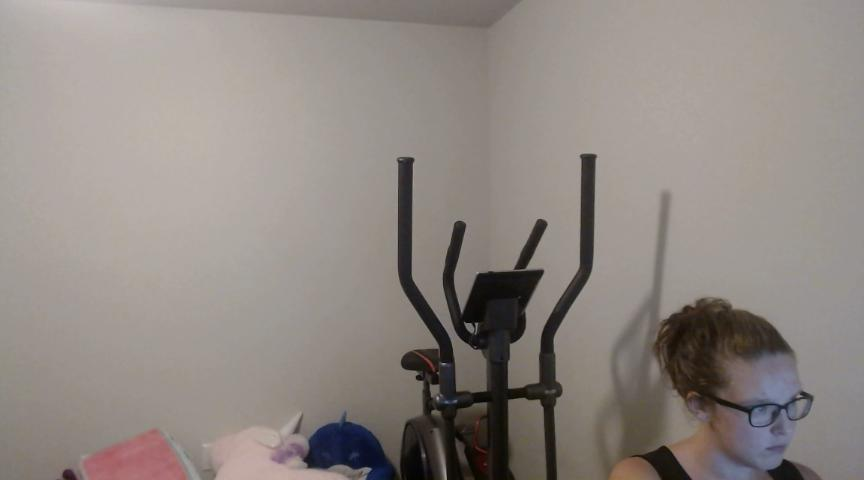

In [ ]:
import sys
!{sys.executable} -m pip install pafy
!{sys.executable} -m pip install youtube-dl
!{sys.executable} -m pip install python-dotenv
!{sys.executable} -m pip install facenet-pytorch

import zmq
import pafy
import numpy as np
import time
from os import getenv
import os
from dotenv import load_dotenv
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import ipywidgets
import traitlets
import PIL
from IPython.display import display, Image
from jetcam.utils import bgr8_to_jpeg
import IPython
from jetcam.usb_camera import USBCamera
from facenet_pytorch import MTCNN
from VideoStream import VideoStream
from LinkedStream import LinkedStream
from IPython.display import Image
import cv2

mean = torch.Tensor([0.485, 0.456, 0.406]).cuda()
std = torch.Tensor([0.229, 0.224, 0.225]).cuda()

device = torch.device('cuda')
model = torchvision.models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(512, 2)
model = model.to(device)
model.load_state_dict(torch.load('./model/my_model(1).pth'))
model.eval()
print("model loaded")

mtcnn = MTCNN(keep_all=True, device='cuda:0')

load_dotenv()
outframe = None
url = "https://youtu.be/7PYzSXHd6U4"
livestream = VideoStream()
linkedstream = LinkedStream(url)
print("camera created")

#defaults
active = "Live"
default_radius_size = getenv('DEFAULT_RADIUS')
default_radius_uom = getenv('DEFAULT_RADIUS_UOM')
default_duration = getenv('DEFAULT_DURATION')
default_duration_uom = getenv('DEFAULT_DURATION_UOM')
message = None

#working values
radius_size = getenv('DEFAULT_RADIUS')
radius_uom = getenv('DEFAULT_RADIUS_UOM')
duration = getenv('DEFAULT_DURATION')
duration_uom = getenv('DEFAULT_DURATION_UOM')

def preprocess(image):
    device = torch.device('cuda')
    image = PIL.Image.fromarray(image)
    image = transforms.functional.to_tensor(image).to(device)
    image.sub_(mean[:, None, None]).div_(std[:, None, None])
    return image[None, ...]

def change_source(change):
    global active
    active = change['new']
   
state_widget = ipywidgets.ToggleButtons(options=['Live', 'Playback'], value='Live')
state_widget.observe(change_source, names='value')

all_widget = ipywidgets.VBox([
    state_widget
])
display(state_widget)
display_handle = display(None, display_id=True)

time.sleep(0.05)
while True:
    (conf, frame) = livestream.read() if active == "Live" else linkedstream.read()
    small_frame = cv2.resize(frame, (int(frame.shape[0]/2), int(frame.shape[1]/2)), interpolation=cv2.INTER_AREA)
    boxes, probs = mtcnn.detect(small_frame) # TODO: THIS ISN'T DETECTING ANYTHING
    if boxes is not None:
        for box, prob, ld in zip(boxes, probs):
            processed = preprocess(small_frame)
            output = model(processed)
            output = F.softmax(output, dim=1).detach().cpu().numpy().flatten()
            category_index = output.argmax()
            if output[category_index] > 0.6:
                color = (0, 0, 255) if category_index else (0, 255, 0)
                label = "No MASK" if category_index else "MASK"
                print(box)
    #img = cv2.rectangle(frame, start_point, end_point, color, 2)  # draw class box
    #        text = "{}:{:.2f}".format(label, score[0])
    #        cv2.putText(frame, text, start_point, cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)  # print class type with score
    #        frame = cv2.rectangle(frame, start_point, end_point, color, 2)
    #draw.rectangle(box.tolist(), outline=(255,0,0), width=6)
    #d.update(frame)
    encode_parameters = [int(cv2.IMWRITE_JPEG_QUALITY),75]
    encode_state, encoded = cv2.imencode('.jpg', frame, encode_parameters)
    binary_image = encoded.tobytes()
    display_handle.update(Image(data=binary_image))